In [1]:
import numpy as np
import sys
sys.path.append("..")
import torch
from matplotlib import pyplot as plt
from inflation import BBI
import time
import json


In [2]:
center1 = torch.tensor([-2.,-2.])
center2 = torch.tensor([2.,2.])

def potential(xs):
    return -torch.exp(-.4*torch.norm(xs-center1)**2)-(1.0-.00000275)*torch.exp(-.8*torch.norm(xs-center2)**2)+0.001*(torch.norm(xs-center1)**2)*(torch.norm(xs-center2)**2)+1.0
V1 = potential(center1)
V2 = potential(center2)

print(V1)
print(V2)

tensor(0.)
tensor(0.)


In [3]:
#The eigenvalues code
xs1 = center1.detach().clone()+0.000001
xs1.requires_grad=True
eigen1 = torch.linalg.eig(torch.autograd.functional.hessian(potential,xs1))[0].real
print(eigen1)
xs2 = center2.detach().clone()+0.000001
xs2.requires_grad=True
eigen2 = torch.linalg.eig(torch.autograd.functional.hessian(potential,xs2))[0].real

print(eigen2)

prod1 = 1.0
for elem in eigen1: prod1*=elem
prod2 = 1.0
for elem in eigen2: prod2*=elem
prod1 = torch.sqrt(prod1)
prod2 = torch.sqrt(prod2)
ratio12 = prod1/prod2
ratio_theory_norm = (1.0/ratio12)
print(ratio_theory_norm)



tensor([0.8640, 0.8640])
tensor([1.6640, 1.6639])
tensor(1.9259)


In [4]:
#This defines the basin regions, as in the appendix
def eta1(xs):
    return torch.sqrt(eigen1)*(xs-center1)

def eta2(xs):
    return torch.sqrt(eigen2)*(xs-center2)

e1  = eigen1[0]
e2  = eigen2[0]

def produce_circle_1(theta):
    return [ (center1[0]+(1.0/torch.sqrt(e1))*torch.cos(torch.tensor(theta))).item(),(center1[1]+(1.0/torch.sqrt(e1))*torch.sin(torch.tensor(theta))).item()]

def produce_circle_2(theta):
    return [ (center2[0]+(1.0/torch.sqrt(e2))*torch.cos(torch.tensor(theta))).item(),(center2[1]+(1.0/torch.sqrt(e2))*torch.sin(torch.tensor(theta))).item()]

def close1(xs):
    if torch.norm(eta1(xs)) < 1: return True
    else: return False
    
def close2(xs):
    if torch.norm(eta2(xs)) < 1: return True
    else: return False



In [5]:
#common params
total_steps = 25000
n_fixed_bounces = 1
lr = 1e-2
threshold = 750
threshold0 = 20
v0 = 0.001
deltaEn = 0
consEn = True

#starting point
xs_region = torch.tensor([10.0,-10.0])
print("Initial value:", potential(xs_region).item())

Initial value: 44.263999938964844


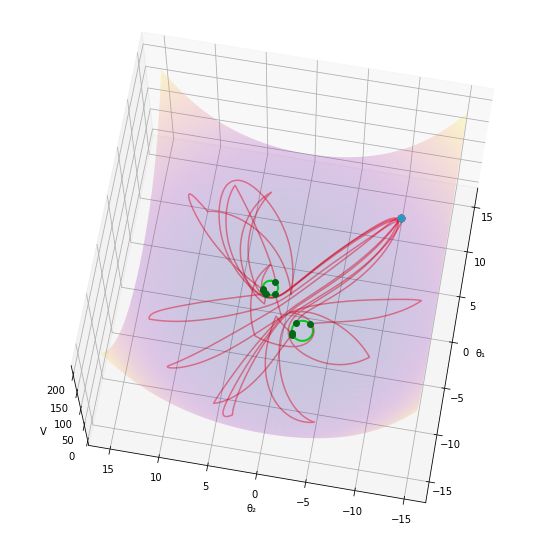

In [6]:
# Generate many trajectories and plot them
n_traj = 10

n_close1 = 0
n_close2 = 0
xs_lists = []
loss_lists = []

for traj in range(n_traj):

    xs = xs_region.detach().clone()
    xs.requires_grad=True

    def loss(xs): return potential(xs)

    optimizer = BBI([xs], lr=lr, threshold0=threshold0, threshold=threshold, v0 = v0, n_fixed_bounces = n_fixed_bounces, consEn = consEn)

    e0 = loss(xs)
    losses=[]
    xs_list=[]
    init_time = time.time()

    for i in range(total_steps):
        optimizer.zero_grad()
        loss_fn=loss(xs)
        losses.append(loss_fn.item())
        xs_list.append(xs.tolist())
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
        with torch.no_grad():
                if close1(xs): 
                    n_close1 += 1
                    break

                if close2(xs): 
                    n_close2 += 1
                    break
    xs_lists.append(xs_list)
    loss_lists.append(losses)

x_interval = (-15,15)
y_interval = (-15,15)


x_points = np.linspace(x_interval[0], x_interval[1], 200)
y_points = np.linspace(y_interval[0], y_interval[1], 200)
X, Y = np.meshgrid(x_points, y_points)

theta_points = np.linspace(0, 2*np.pi, 100)


def potential_vec(X,Y, potential):
    Z = []
    for i in range(len(X)):
        Z1 = []
        for j in range(len(X[i])):
            Z1.append(potential(torch.tensor([X[i][j],Y[i][j]])))
        Z.append(Z1)
    return np.array(Z)


Z = potential_vec(X, Y, potential)

plt.figure(figsize=(20, 10))

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='plasma', edgecolor=None, alpha=.2)

ax.set(xlabel='θ₁', ylabel='θ₂', zlabel='V')

x_line_c1 = []
y_line_c1 = []
z_line_c1 = []

x_line_c2 = []
y_line_c2 = []
z_line_c2 = []

for elem in theta_points:
    temp = produce_circle_1(elem)
    x_line_c1.append(temp[0])
    y_line_c1.append(temp[1])
    z_line_c1.append(potential(torch.tensor(temp)).item())

    temp = produce_circle_2(elem)
    x_line_c2.append(temp[0])
    y_line_c2.append(temp[1])
    z_line_c2.append(potential(torch.tensor(temp)).item())


ax.plot3D(np.array(x_line_c1), np.array(y_line_c1),  np.array(z_line_c1), 'lime', alpha=1.0, linewidth = 2 )
ax.plot3D(np.array(x_line_c2), np.array(y_line_c2),  np.array(z_line_c2), 'lime', alpha=1.0, linewidth = 2)

traj = 0

for traj in range(n_traj):

    plot_list = xs_lists[traj]

    x_line = []
    y_line = []
    for elem in plot_list:
        x_line.append(elem[0])
        y_line.append(elem[1])
        
    
    ax.plot3D(np.array(x_line), np.array(y_line), np.array(loss_lists[traj]), 'red',alpha=.45)
    ax.view_init(70, 190)
    ax.scatter(xs_region[0].item(), xs_region[1].item(), potential(xs_region).item(), marker='o', s = 45)
    ax.scatter(plot_list[-1][0], plot_list[-1][1], loss_lists[traj][-1], marker='o', s = 35, color='green')
plt.savefig('sample-traj-basins.pdf', bbox_inches='tight')



In [7]:
#A scan

nruns = 2000

def loss(xs): return potential(xs)

e0 = loss(xs)
n_close1 = 0
n_close2 = 0

partial_ratios = []

init_time = time.time()

for j in range(nruns):

    if(n_close2 != 0): ratio = n_close1/n_close2
    else: ratio = np.inf
    
    partial_ratios.append(ratio)

    if j%int(nruns/10) == 0:
        print("Run: ", j, "\tInside 1: ", n_close1, "\t\tInside 2: " , n_close2,  "\t\tRatio: ", ratio)

    xs = xs_region.detach().clone()
    xs.requires_grad=True
    optimizer = BBI([xs], lr=lr, threshold0=threshold0, threshold=threshold, v0 = v0, n_fixed_bounces = n_fixed_bounces, consEn = consEn, deltaEn = deltaEn)
 
    for i in range(total_steps):
        optimizer.zero_grad()
        loss_fn=loss(xs)
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
        with torch.no_grad():
            if close1(xs): 
                n_close1 += 1
                break

            if close2(xs): 
                n_close2 += 1
                break
                

print("\nTotal runs: ", n_close1+n_close2)
print("Final ratio: " , n_close1/n_close2)
print("Total time: ", time.time()-init_time)

with open('multi_basin_scan_result.txt', 'w') as filehandle:
    json.dump( partial_ratios, filehandle)


Run:  0 	Inside 1:  0 		Inside 2:  0 		Ratio:  inf
Run:  200 	Inside 1:  115 		Inside 2:  85 		Ratio:  1.3529411764705883
Run:  400 	Inside 1:  240 		Inside 2:  160 		Ratio:  1.5
Run:  600 	Inside 1:  371 		Inside 2:  229 		Ratio:  1.6200873362445414
Run:  800 	Inside 1:  501 		Inside 2:  299 		Ratio:  1.6755852842809364
Run:  1000 	Inside 1:  635 		Inside 2:  365 		Ratio:  1.7397260273972603
Run:  1200 	Inside 1:  760 		Inside 2:  440 		Ratio:  1.7272727272727273
Run:  1400 	Inside 1:  889 		Inside 2:  511 		Ratio:  1.7397260273972603
Run:  1600 	Inside 1:  1019 		Inside 2:  581 		Ratio:  1.7538726333907058
Run:  1800 	Inside 1:  1139 		Inside 2:  661 		Ratio:  1.7231467473524962

Total runs:  2000
Final ratio:  1.7247956403269755
Total time:  2184.3379504680634


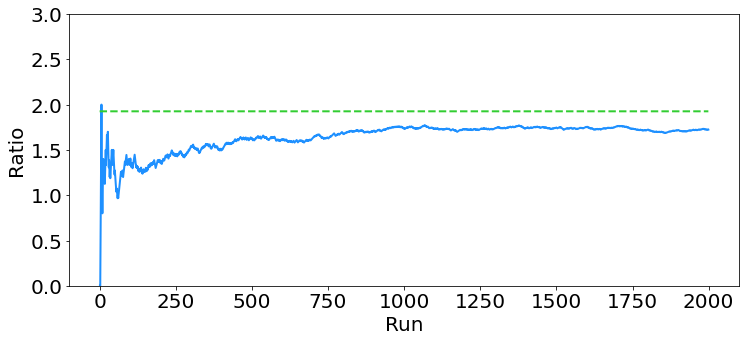

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(partial_ratios, label="Empirical", color ='dodgerblue', linewidth=2)
plt.plot([ (1.0/ratio12).item() for i in range(len(partial_ratios))], '--', label= "If mixing", color = 'limegreen', linewidth=2)
plt.ylabel("Ratio", fontsize = 20)
plt.xlabel("Run", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([0, 3])
plt.savefig('ratios.pdf',bbox_inches='tight')

In [9]:
ratio_theory_norm = (1.0/ratio12)
ratio_experiment = n_close1/n_close2
(ratio_theory_norm-ratio_experiment)/ratio_theory_norm

tensor(0.1044)